# CPU vs GPU Performance on Pytorch NN Models

##### Al-sharif, Muhammad

In this notebook, Pytorch's nn package is used to construct four convolutional neural networks of increasing sizes. The goal is to measure the forward and backward passes of these models as they are run on CPU and GPU. We are also looking to observe any correlation between the GPU gain and the neural network size/complixity. I used my solution of the pytorch assignment given by [1] as a starting point for this notebook.

### Table of Contents
* [2-Layer Model](#2-Layer-Model)
* [3-Layer Model](#3-Layer-Model)
* [6-Layer Model](#6-Layer-Model)
* [18-Layer Model (ResNet)](#18-Layer-Model---ResNet)
* [Results Summary](#Results-Summary)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision.models as models    #for ResNet

import numpy as np
import matplotlib.pyplot as plt
import copy
import timeit

In [2]:
# create the input and output variables on CPU

x_var = Variable(torch.randn(64, 3, 32, 32))
y_var = Variable(torch.LongTensor(64).random_(10))

In [3]:
# verify that Nvidia GPU is avialable

!nvidia-smi

Mon Oct  2 14:16:06 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.59                 Driver Version: 384.59                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  NVS 315             Off  | 00000000:02:00.0 N/A |                  N/A |
| 30%   37C    P8    N/A /  N/A |    104MiB /   964MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   34C    P8    15W / 250W |      2MiB / 12207MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
# verify that CUDA is properly configured

torch.cuda.is_available()

True

In [5]:
dtype = torch.FloatTensor          # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor # the GPU datatype

In [6]:
# copy the x and y vars to GPU

x_var_gpu = x_var.cuda()
y_var_gpu = y_var.cuda()

In [7]:
loss_fn = nn.CrossEntropyLoss()

In [8]:
# this layer is useful when used in nn.Sequential since the input has to be flattened before it is
# fed into a fully connected layer

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

## 2-Layer Model

We start by defining a simple two-layer model. By using nn.Sequential, each layer will be composed upon the previous layer. First, there is a 2D convolutional layer (Conv2d), then ReLU activation, and finally a fully-connected layer (Linear).


In [9]:
simple_model_base = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=7, stride=2),
                    nn.ReLU(inplace=True),
                    Flatten(), # see above for explanation
                    nn.Linear(5408, 10), # affine layer
                  )

In [10]:
simple_model = simple_model_base.type(dtype)
simple_model_gpu = copy.deepcopy(simple_model_base).type(gpu_dtype)

### A. The Forward Pass

#### 1. On CPU

In [11]:
%%timeit 
ans = simple_model.forward(x_var)

4.28 ms ± 905 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 2. On GPU

In [12]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = simple_model_gpu.forward(x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

404 µs ± 69.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### B. The Backward Pass

#### 1. On CPU

In [13]:
scores = simple_model.forward(x_var)
loss = loss_fn(scores, y_var)
#optimizer = optim.SGD(simple_model.parameters(), lr=1e-3)

In [14]:
%%timeit
#optimizer.zero_grad()
loss.backward(retain_graph=True)

2.87 ms ± 5.09 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### 2. On GPU

In [15]:
scores_gpu = simple_model_gpu.forward(x_var_gpu)
loss_gpu = loss_fn(scores_gpu, y_var_gpu)
#optimizer_gpu = optim.SGD(simple_model_gpu.parameters(), lr=1e-3)

In [16]:
%%timeit
torch.cuda.synchronize()
#optimizer_gpu.zero_grad()
loss_gpu.backward(retain_graph=True)
torch.cuda.synchronize()

1.16 ms ± 5.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 3-Layer Model

Here, we define a slightly more complex model than the 2-layer model. This has the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs


In [17]:
model3_base = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=7, stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    Flatten(),
                    nn.Linear(5408, 1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024, 10)
            )

In [18]:
model3 = model3_base.type(dtype)
model3_gpu = copy.deepcopy(model3_base).type(gpu_dtype)

### A. The Forward Pass

#### 1. On CPU

In [19]:
%%timeit 
ans = model3.forward(x_var)

17.2 ms ± 9.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### 2. On GPU

In [20]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = model3_gpu.forward(x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

955 µs ± 738 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### B. The Backward Pass

#### 1. On CPU

In [21]:
scores = model3.forward(x_var)
loss = loss_fn(scores, y_var)
#optimizer = optim.SGD(model3.parameters(), lr=1e-3)

In [22]:
%%timeit
#optimizer.zero_grad()
loss.backward(retain_graph=True)

18.9 ms ± 8.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### 2. On GPU

In [23]:
scores_gpu = model3_gpu.forward(x_var_gpu)
loss_gpu = loss_fn(scores_gpu, y_var_gpu)
#optimizer_gpu = optim.SGD(model3_gpu.parameters(), lr=1e-3)

In [24]:
%%timeit
torch.cuda.synchronize()
#optimizer_gpu.zero_grad()
loss_gpu.backward(retain_graph=True)
torch.cuda.synchronize()

2.49 ms ± 6.02 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 6-Layer Model

Here, we construct an even more complex 6-layer model. It is uniformally structured with 3x3 convolutional layers with 32 filters and a stride of 1 followed by a ReLU activation. We insert a 2x2 max pooling layer with a stride of 2 after every two convolutional layers. Finally, we add two fully connected layers.

In [25]:
model6_base = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                Flatten(),
                nn.Linear(2048, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 10)
            )

In [26]:
model6 = model6_base.type(dtype)
model6_gpu = copy.deepcopy(model6_base).type(gpu_dtype)

### A. The Forward Pass

#### 1. On CPU

In [27]:
%%timeit 
ans = model6.forward(x_var)

55.7 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### 2. On GPU

In [28]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = model6_gpu.forward(x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

1.19 ms ± 154 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### B. The Backward Pass

#### 1. On CPU

In [29]:
scores = model6.forward(x_var)
loss = loss_fn(scores, y_var)
#optimizer = optim.SGD(model6.parameters(), lr=1e-3)

In [30]:
%%timeit
#optimizer.zero_grad()
loss.backward(retain_graph=True)

70 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### 2. On GPU

In [31]:
scores_gpu = model6_gpu.forward(x_var_gpu)
loss_gpu = loss_fn(scores_gpu, y_var_gpu)
#optimizer_gpu = optim.SGD(model6_gpu.parameters(), lr=1e-3)

In [32]:
%%timeit
torch.cuda.synchronize()
#optimizer_gpu.zero_grad()
loss_gpu.backward(retain_graph=True)
torch.cuda.synchronize()

4.01 ms ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 18-Layer Model - ResNet

Residual net (ResNet) won ILSVRC 2015 ImageNet competition with an incredible error rate of 3.6% [2]. The images in this dataset are relatively large with 1000 different classes. This model along with several popular ones are already implemented in Pytorch, so here we will just import it (the simpler one with 18 layers).

In [33]:
big_x_var = Variable(torch.randn(64, 3, 256, 256))
big_y_var = Variable(torch.LongTensor(64).random_(1000))

In [34]:
big_x_var_gpu = big_x_var.cuda()
big_y_var_gpu = big_y_var.cuda()

In [35]:
resnet18 = models.resnet18()   #also try: models.resnet34() or models.resnet50() or models.resnet101()

In [36]:
resnet18

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [37]:
resnet18_gpu = copy.deepcopy(resnet18).type(gpu_dtype)

### A. The Forward Pass

#### 1. On CPU

In [38]:
%%timeit 
ans = resnet18.forward(big_x_var)

5.75 s ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 2. On GPU

In [39]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = resnet18_gpu.forward(big_x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

94.9 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### B. The Backward Pass

#### 1. On CPU

In [40]:
scores = resnet18.forward(big_x_var)
loss = loss_fn(scores, big_y_var)
#optimizer = optim.SGD(resnet18.parameters(), lr=1e-3)

In [41]:
%%timeit
#optimizer.zero_grad()
loss.backward(retain_graph=True)

5.72 s ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 2. On GPU

In [42]:
scores_gpu = resnet18_gpu.forward(big_x_var_gpu)
loss_gpu = loss_fn(scores_gpu, big_y_var_gpu)
#optimizer_gpu = optim.SGD(resnet18_gpu.parameters(), lr=1e-3)

In [43]:
%%timeit
torch.cuda.synchronize()
#optimizer_gpu.zero_grad()
loss_gpu.backward(retain_graph=True)
torch.cuda.synchronize()

183 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Results Summary

In all four convolutional nets above, doing the forawrd or backward pass on GPU yeilds a signifiant performance over CPU. In the cells bellow, we calculate the GPU gain which shows that it increases as the size of the conv model and/or the batch size increases. Finally, we plot the bar charts for the CPU/GPU execution times over the four models.

In [44]:
forward_cpu = np.array([4.28, 17.2, 55.7, 5750])  #in ms
forward_gpu = np.array([0.404, 0.955, 1.19, 94.9])  #in ms

In [45]:
backward_cpu = np.array([2.87, 18.9, 70, 5720])  #in ms
backward_gpu = np.array([1.16, 2.49, 4.01, 183])  #in ms

In [46]:
forward_gpu_gain = forward_cpu / forward_gpu
forward_gpu_gain

array([ 10.59405941,  18.0104712 ,  46.80672269,  60.59009484])

In [47]:
backward_gpu_gain = backward_cpu / backward_gpu
backward_gpu_gain

array([  2.47413793,   7.59036145,  17.4563591 ,  31.2568306 ])

In [48]:
def bar_chart(cpu_times, gpu_times, title, log_scale=True):
    n_groups = 4
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, cpu_times, bar_width,
                     log=log_scale,
                     alpha=opacity,
                     color='b',
                     label='CPU')

    rects2 = plt.bar(index + bar_width, gpu_times, bar_width,
                     log=log_scale,
                     alpha=opacity,
                     color='g',
                     label='GPU')

    plt.xlabel('Model')
    add_label = '- log scale' if log_scale else ''
    plt.ylabel("Time (ms) " + add_label)
    plt.title(title)
    plt.xticks(index + bar_width, ('2-layer', '3-layer', '6-layer', '18-layer (ResNet)'))
    plt.legend()

    plt.tight_layout()
    plt.show()

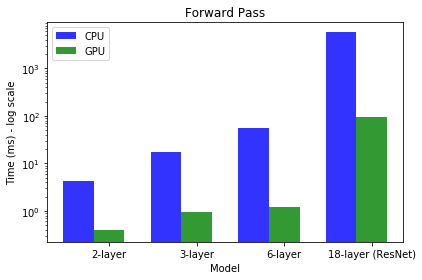

In [49]:
bar_chart(forward_cpu, forward_gpu, title='Forward Pass', log_scale=True)

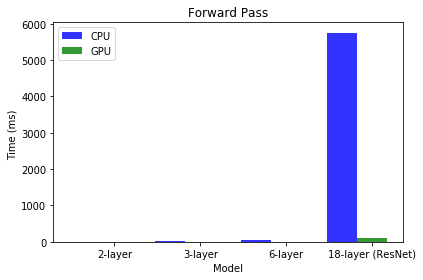

In [50]:
bar_chart(forward_cpu, forward_gpu, title='Forward Pass', log_scale=False)

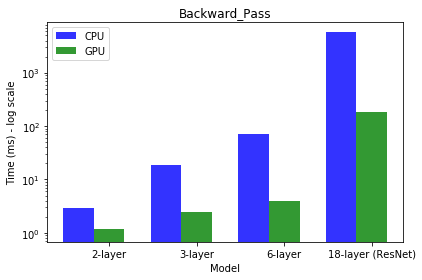

In [51]:
bar_chart(backward_cpu, backward_gpu, title='Backward_Pass', log_scale=True)

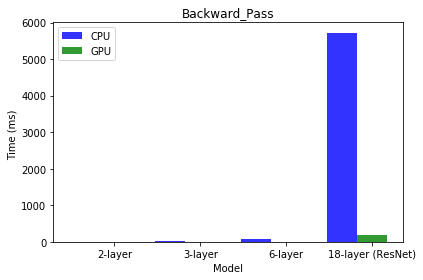

In [52]:
bar_chart(backward_cpu, backward_gpu, title='Backward_Pass', log_scale=False)

## References

[1] Stanford University CS231n: Convolutional Neural Networks for Visual Recognition, 2 Aug. 2017, cs231n.stanford.edu.

[2] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.